In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import os
import pickle
import operator
import itertools
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData, GenomicBins
from bgspy.utils import mean_ratio, BScores
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, exact_index

2022-11-09 10:09:47.476870: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/vsb/projects/bprime/bgspy/data.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

In [5]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)


## Load Data

### bgspy B maps

In [63]:
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_sims_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

bp = m.BpScores
b = m.BScores

In [64]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([1.00e-06, 3.16e-06, 1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04,
        1.00e-03, 3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01]))

In [65]:
bp.B['chr10'].shape

(13381, 6, 11, 1)

In [138]:
pkl_b_file = '../data/bmaps/bgspy/chr10_hetsum.pkl'
ma = BGSModel.load(pkl_b_file)

bpa = ma.BpScores
ba = ma.BScores

### McVicker's `calc_bkgd` 

In [9]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_100000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)
mcvb.w, mcvb.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

### Simulation Data

`sim_B` is a `.npz` object with mean, variance, and the raw data for all replicates (`X`).

In [32]:
sim_B = np.load('../data/slim_sims/chrombgs_chr10/conserved_cds_utrs_phastcons_merged/conserved_cds_utrs_phastcons_merged.npz', allow_pickle=True)
mus = sim_B['mu']
shs = sim_B['sh']

In [33]:
# shape of raw data -- last dimension is number of replicates
sim_B['X'].shape

(133798, 6, 11, 50)

To get a sense of the variance across simulation replicates, let's average all replicates and look at how the mean varies across chromosomal space.

In [34]:
mus, shs

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([1.00e-06, 3.16e-06, 1.00e-05, 3.16e-05, 1.00e-04, 3.16e-04,
        1.00e-03, 3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01]))

In [35]:
sim_B['X'].shape

(133798, 6, 11, 50)

Now, for convenience we load the means and standard deviations into `BScores` objects.  

In [36]:
# create midpoints
sims_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2

sims_means = BScores({'chr10': np.log(sim_B['mean'])}, {'chr10': sims_pos}, mus, shs, step=None)
sims_sds = BScores({'chr10': np.log(sim_B['sd'])}, {'chr10': sims_pos}, mus, shs, step=None)

In [37]:
sims = BScores({'chr10': np.log(sim_B['X'])}, {'chr10': sims_pos}, mus, shs, step=None)

In [38]:
sim_means_500kb = sims_means.bin_means(GenomicBins(g.seqlens, 500_000))
sim_means_1Mb = sims_means.bin_means(GenomicBins(g.seqlens, 1_000_000))

sim_sd_500kb = sims_sds.bin_means(GenomicBins(g.seqlens, 500_000))
sim_sd_1Mb = sims_sds.bin_means(GenomicBins(g.seqlens, 1_000_000))


In [39]:
sims_1Mb = sims.bin_means(GenomicBins(g.seqlens, 1_000_000))

In [40]:
list(sim_B.keys())

['mu', 'sh', 'pos', 'X', 'nreps', 'mean', 'sd', 'files']

Note that the simulations are heteroscedastic across $B(x)$, and the level varies across parameters (below).

This could be due to varying levels of polymorphism along the genome — except that where diversity is the lowest (low recombination regions), we'd expect fewer segregating sites, and thus *higher* variance; here we see the opposite.

Thus, the BGS process (under strong-ish selection) is reducing the variance in coalescent times.

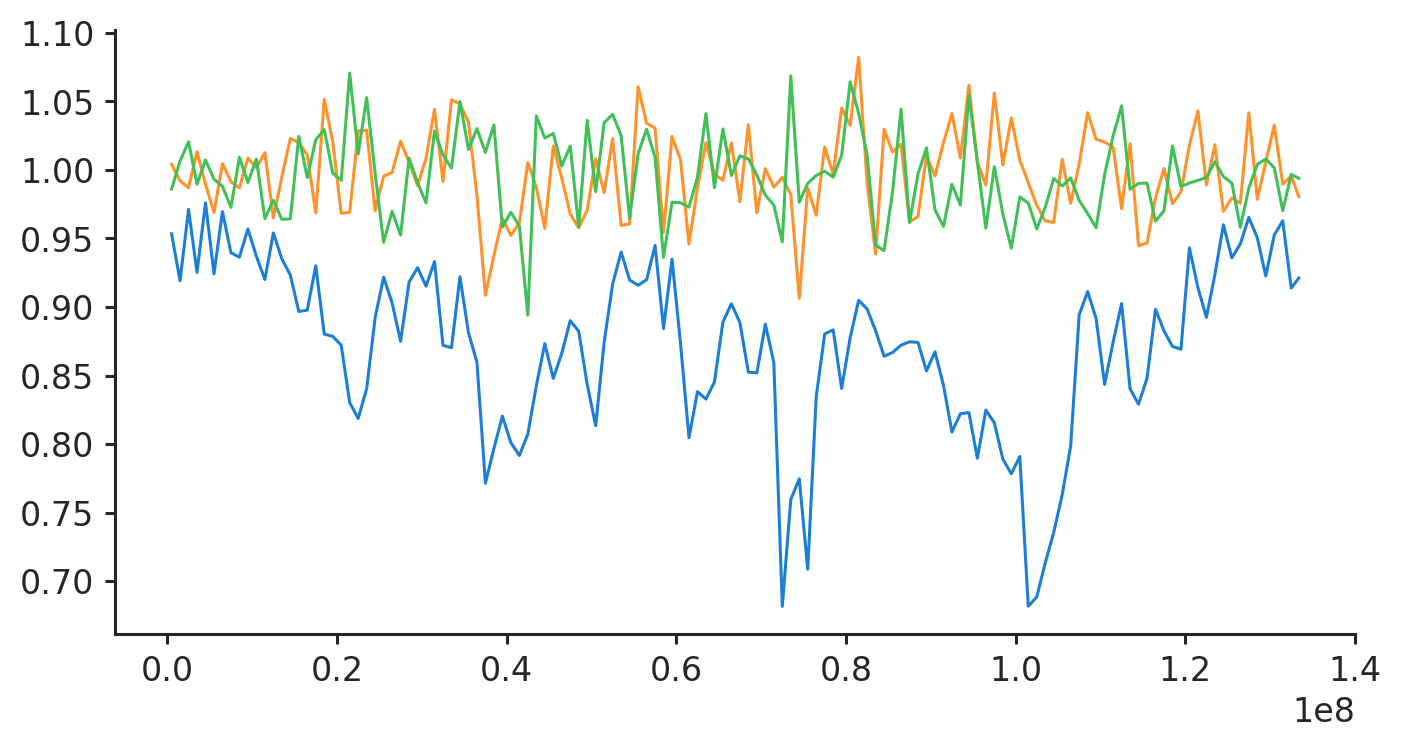

In [42]:
plt.plot(*sim_means_1Mb['chr10', 1e-8, 1e-2])
plt.plot(*sim_means_1Mb['chr10', 1e-8, 1e-4])
plt.plot(*sim_means_1Mb['chr10', 1e-9, 1e-4])

In [135]:
bp.B['chr10'].shape

(13381, 6, 11, 1)

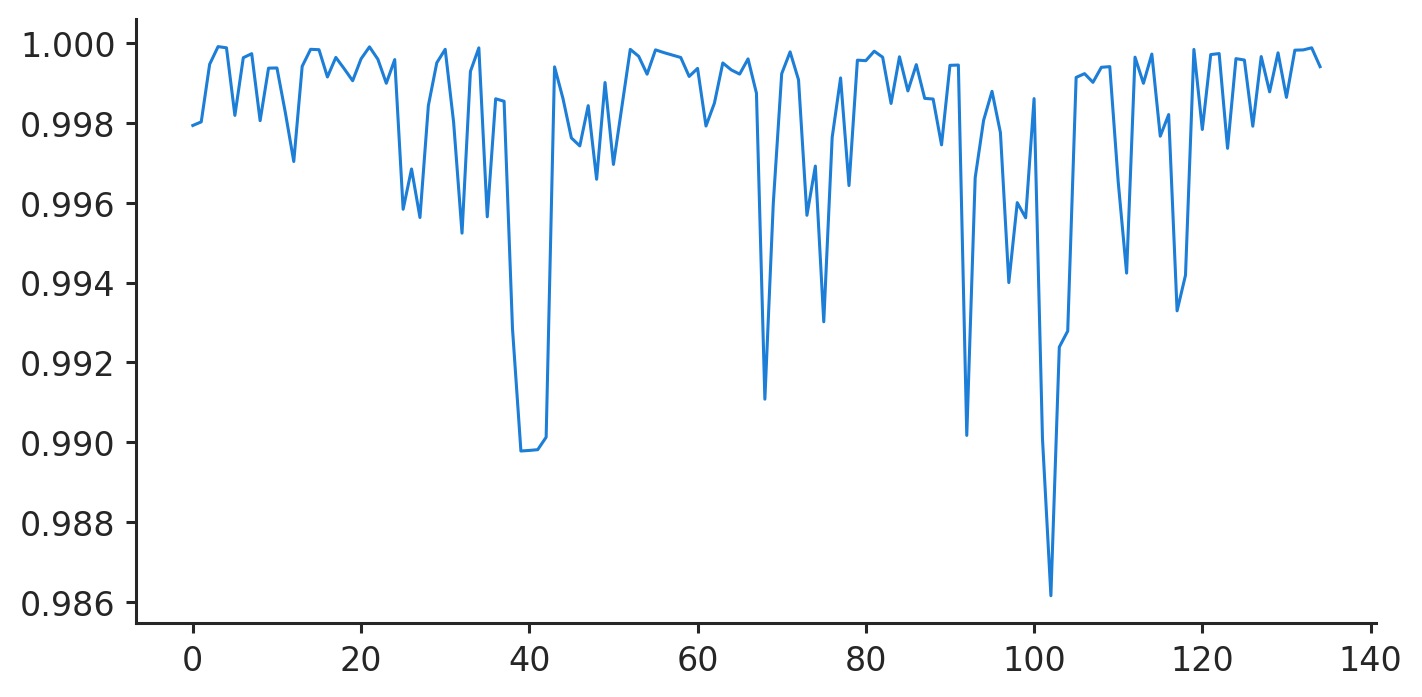

In [141]:
plt.plot(np.exp(bpa.B['chr10'][:, 0, 0, 0]))

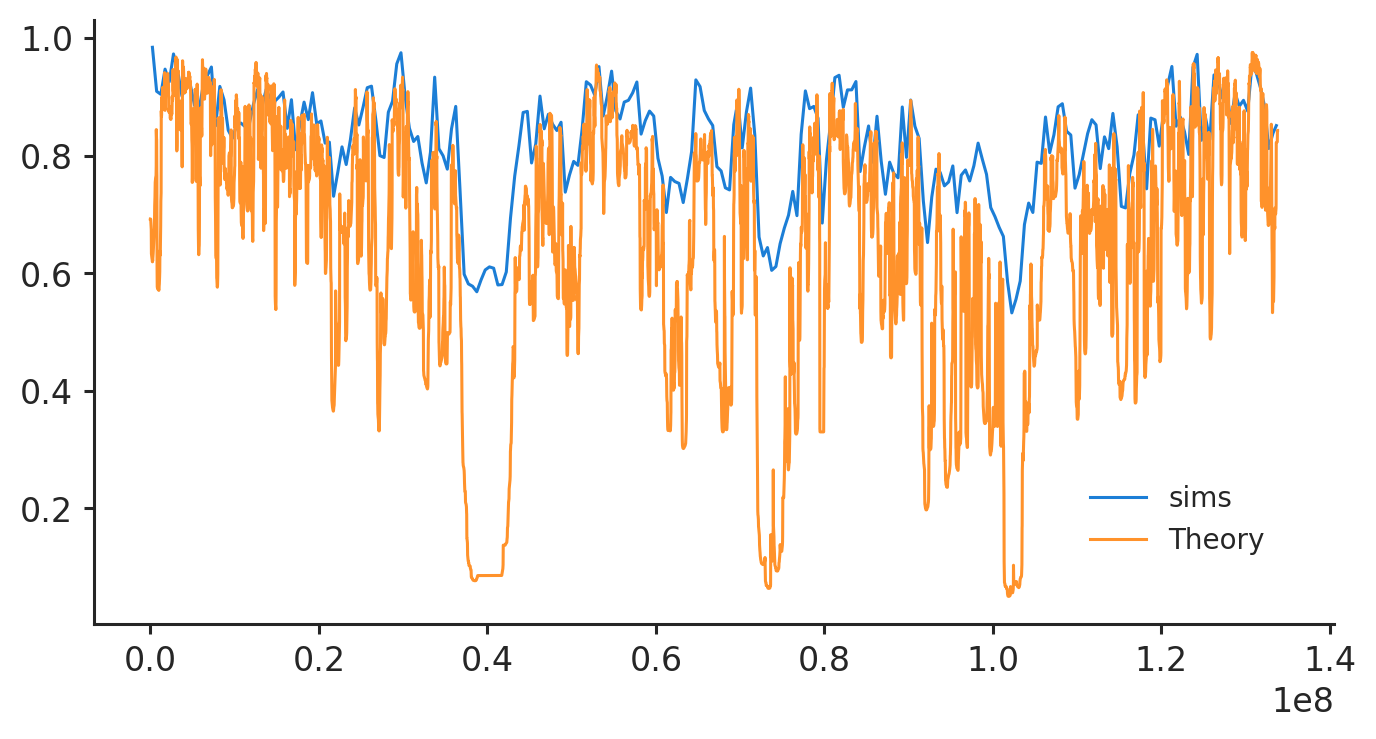

In [145]:
w, t = 3.16e-8, 1e-3
bb = m.BpScores['chr10', w, t]

plt.plot(*sim_means_500kb['chr10', w, t], label="sims")
plt.plot(*bb, label="Theory")

plt.legend()

## At what scale do we see the BGS signal?

In [43]:
# We'll compare this to the real data, becase, why not
hg38_gd = GenomeData(g)
hg38_gd.load_counts_dir('../data/h1kg/hg1k_counts/')
hg38_gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
hg38_gd.load_accessibile_masks('../data/annotation/no_centro.bed')

hg38_bins, hg38_pi = hg38_gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

AttributeError: 'GenomeData' object has no attribute 'bin_pi'

In [21]:
sims_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2
sim_1 = BScores({'chr10': np.log(sim_B['X'][..., 0])}, {'chr10': sims_pos}, mus, shs, step=None)

In [22]:
sim_1_1Mb = sim_1.bin_means(GenomicBins(g.seqlens, 1_000_000))

In [23]:
bp.t

array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
       0.1     ])

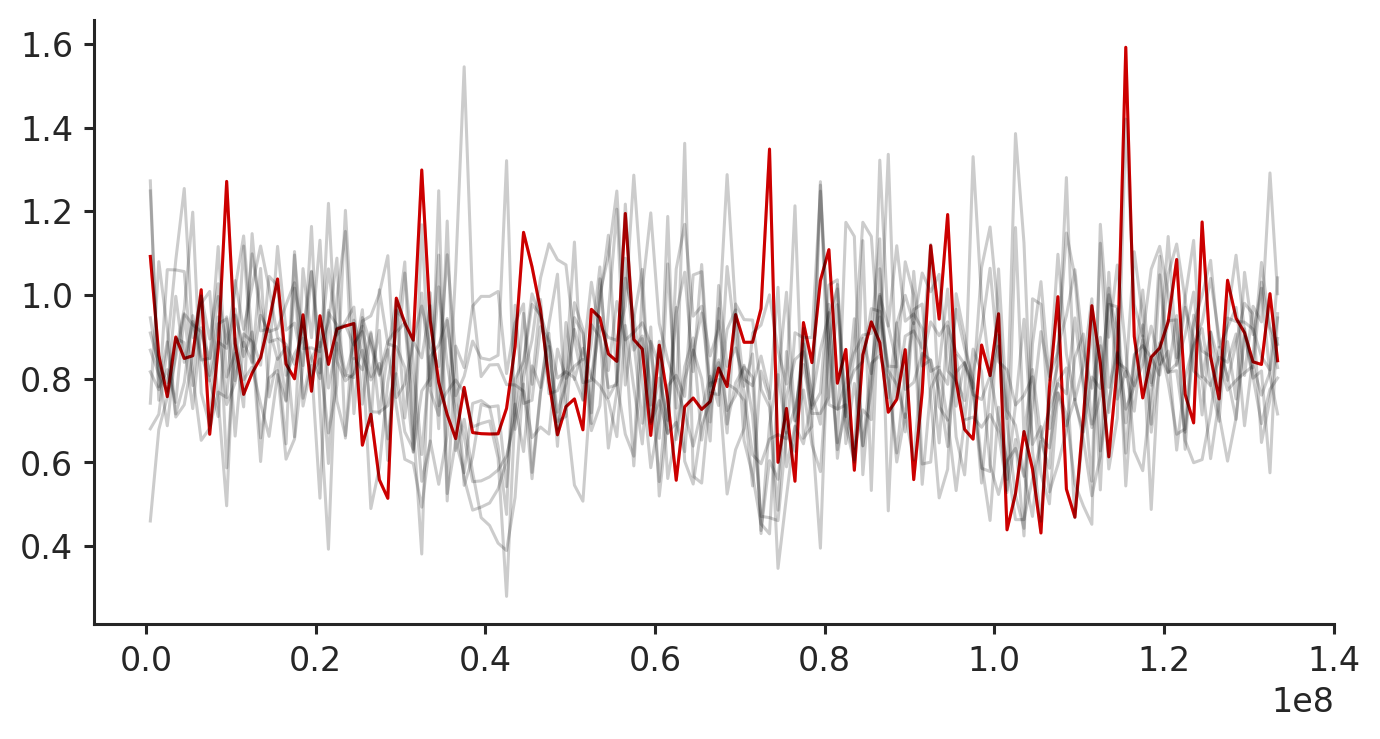

In [24]:
x, y = sim_1_1Mb.pairs('chr10', 1e-8, 1e-2)
_ = plt.plot(x, y, c='r', label='sim mean', zorder=2)

xx, yy = sims_1Mb.pairs('chr10', 1e-8, 1e-2)
for i in range(10):
    plt.plot(xx, yy[:, i], c='k', alpha=0.2)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


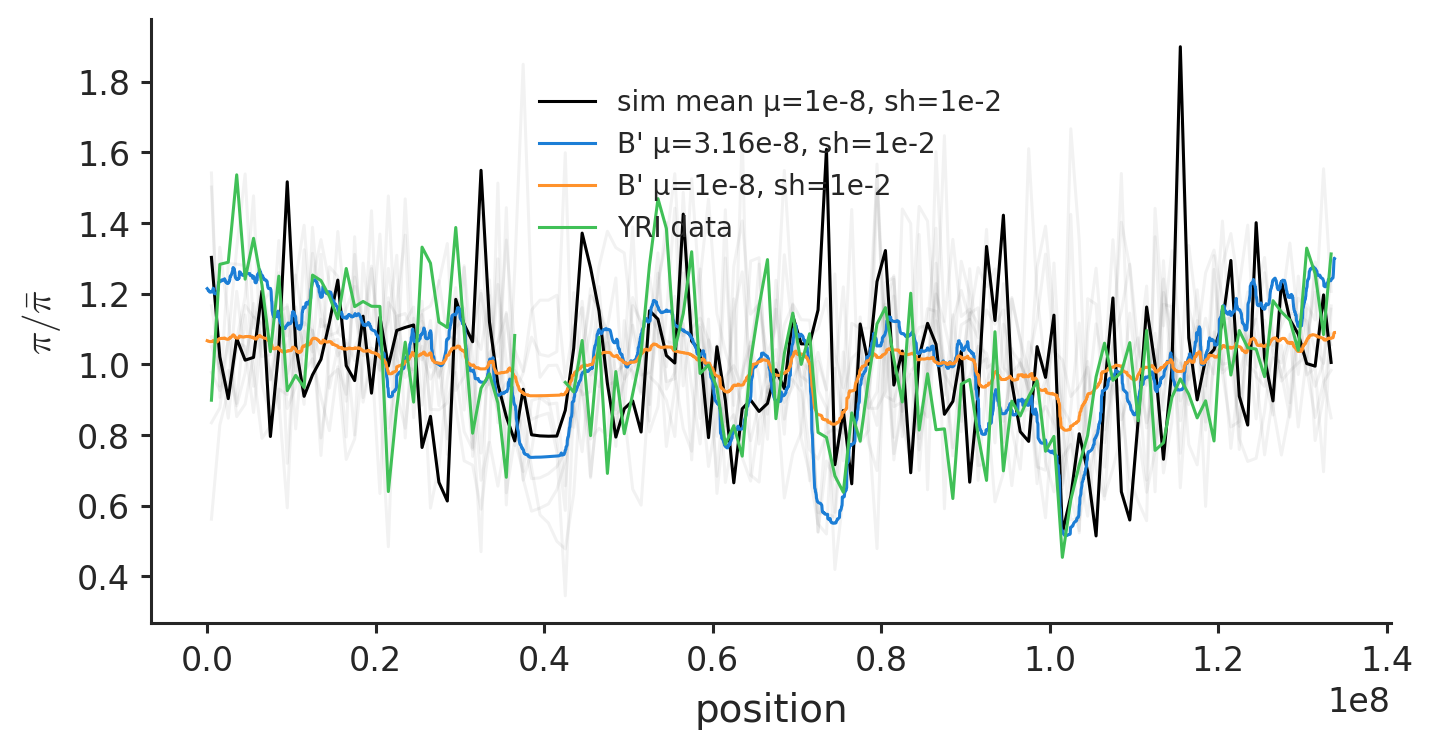

In [25]:
x, y = sim_1_1Mb.pairs('chr10', 1e-8, 1e-2)
_ = plt.plot(x, mean_ratio(y), c='k', label='sim mean μ=1e-8, sh=1e-2')

xx, yy = sims_1Mb.pairs('chr10', 1e-8, 1e-2)
for i in range(10):
    plt.plot(xx, mean_ratio(yy[:, i]), c='k', alpha=0.05)
    
xx, yy = bp.pairs('chr10', 3.16e-8, 1e-2)
plt.plot(xx, mean_ratio(yy), label="B' μ=3.16e-8, sh=1e-2")
xx, yy = bp.pairs('chr10', 1e-8, 1e-2)
plt.plot(xx, mean_ratio(yy), label="B' μ=1e-8, sh=1e-2")
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, mean_ratio(dy), label="YRI data")
plt.ylabel("$\pi / \\bar{\pi}$")
plt.xlabel("position")
plt.legend()
#plt.ylim(0.7, 1.1)

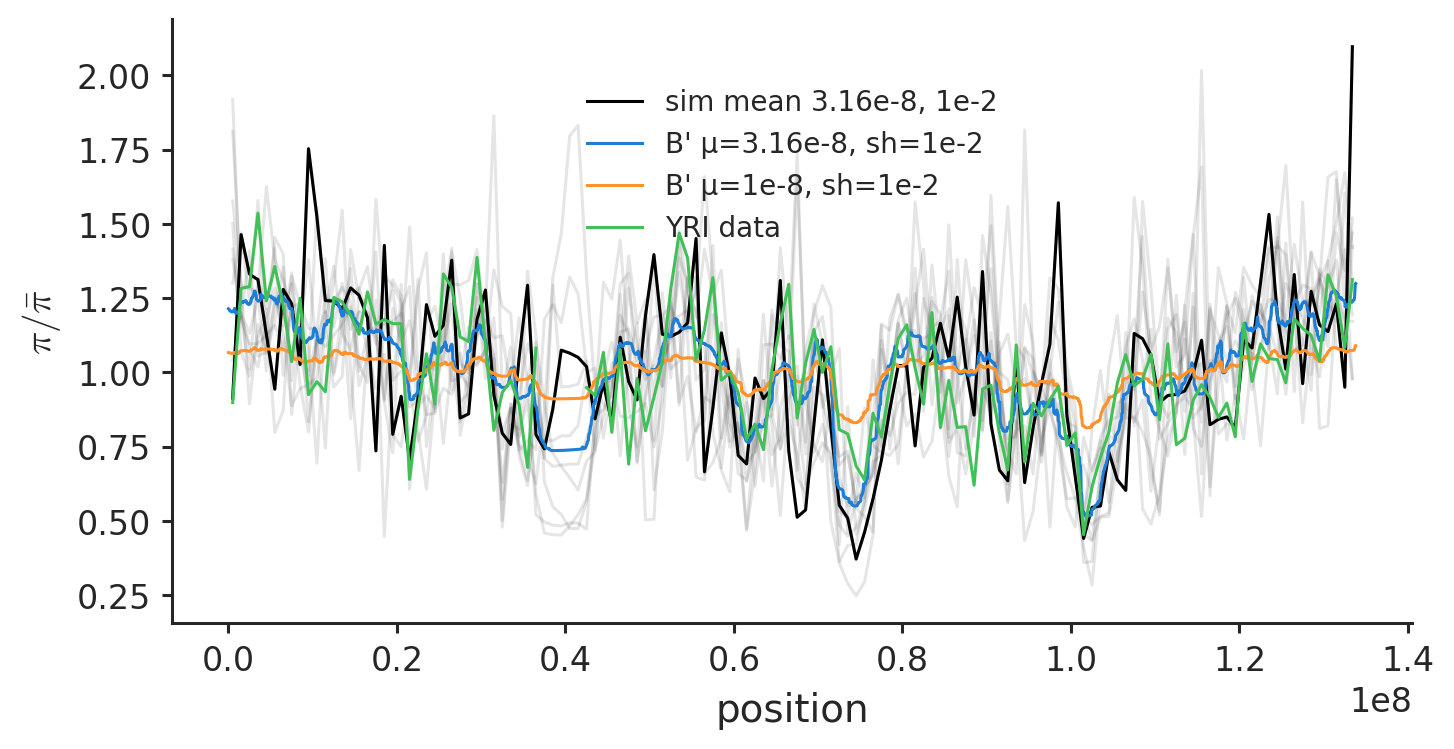

In [26]:
x, y = sim_1_1Mb.pairs('chr10', 3.16e-8, 1e-2)
_ = plt.plot(x, mean_ratio(y), c='k', label='sim mean 3.16e-8, 1e-2')

xx, yy = sims_1Mb.pairs('chr10', 3.16e-8, 1e-2)
for i in range(10):
    plt.plot(xx, mean_ratio(yy[:, i]), c='k', alpha=0.1)
    
xx, yy = bp.pairs('chr10', 3.16e-8, 1e-2)
plt.plot(xx, mean_ratio(yy), label="B' μ=3.16e-8, sh=1e-2")
xx, yy = bp.pairs('chr10', 1e-8, 1e-2)
plt.plot(xx, mean_ratio(yy), label="B' μ=1e-8, sh=1e-2")
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, mean_ratio(dy), label="YRI data")
plt.ylabel("$\pi / \\bar{\pi}$")
plt.xlabel("position")
plt.legend()
#plt.ylim(0.7, 1.1)

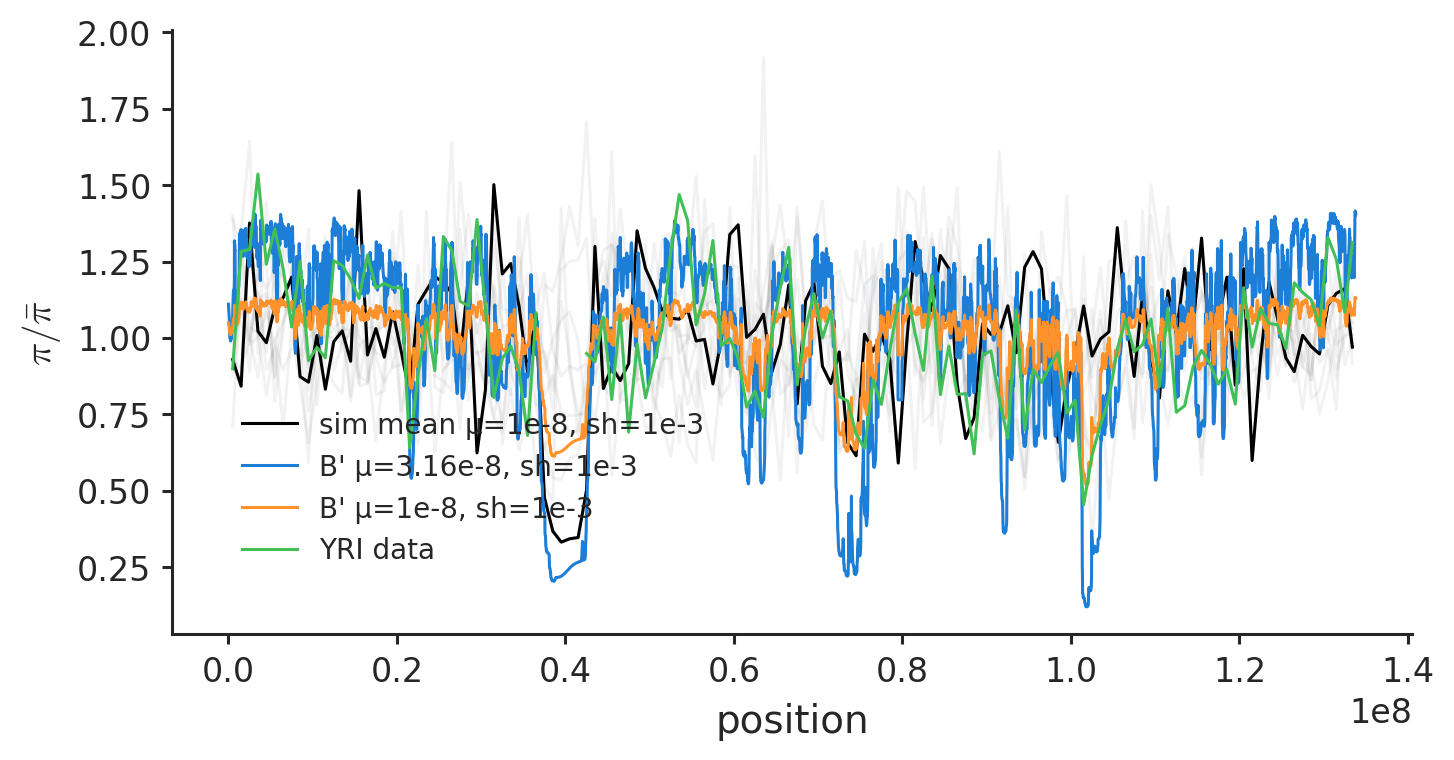

In [53]:
x, y = sim_1_1Mb.pairs('chr10', 1e-8, 1e-3)
_ = plt.plot(x, mean_ratio(y), c='k', label='sim mean μ=1e-8, sh=1e-3')

xx, yy = sims_1Mb.pairs('chr10', 1e-8, 1e-3)
for i in range(10):
    plt.plot(xx, mean_ratio(yy[:, i]), c='k', alpha=0.05)
    
xx, yy = bp.pairs('chr10', 3.16e-8, 1e-3)
plt.plot(xx, mean_ratio(yy), label="B' μ=3.16e-8, sh=1e-3")
xx, yy = bp.pairs('chr10', 1e-8, 1e-3)
plt.plot(xx, mean_ratio(yy), label="B' μ=1e-8, sh=1e-3")
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, mean_ratio(dy), label="YRI data")
plt.ylabel("$\pi / \\bar{\pi}$")
plt.xlabel("position")
plt.legend()
#plt.ylim(0.7, 1.1)

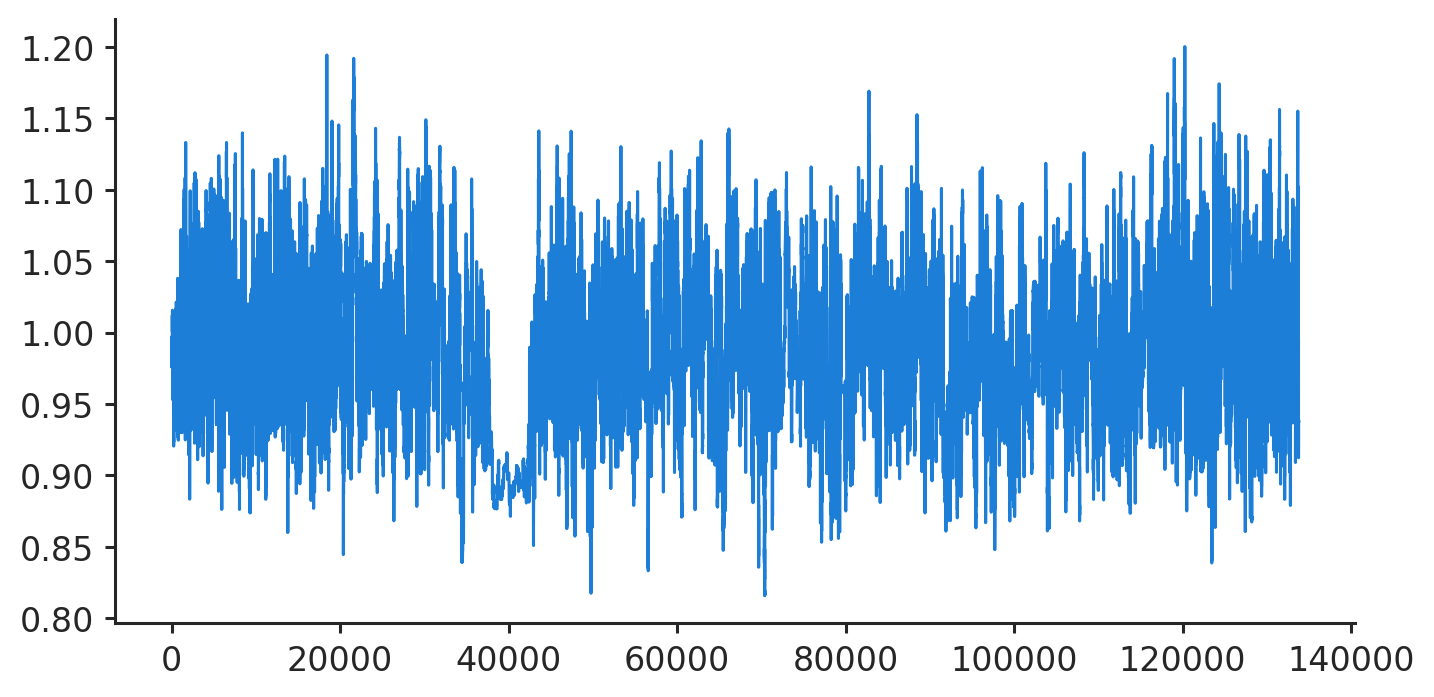

In [27]:
plt.plot(sim_B['X'].mean(axis=3)[:, 2, 5])

## Experiments with Dxy

In [ ]:
plt.scatter(sims_pos, sim_B['X'].mean(axis=3)[:, 2, 5], c='0.22', alpha=0.4, s=1)
plt.xlim(0.3e8, 0.4e8)

In [ ]:
plt.scatter(*sims_means.pairs('chr10', 1e-9, 1e-3), c='0.22', alpha=0.4, s=1)
plt.plot(*bp.pairs('chr10', 1e-9, 1e-4))
plt.plot(*b.pairs('chr10', 1e-9, 1e-4))
#plt.xlim(0.1e8, 0.4e8)


In [ ]:
import pandas as pd

In [ ]:
dalt = pd.read_csv('../data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv', sep='\t')
dalt['midpoint'] = (dalt.start + dalt.end)/2
dalt_pi = dalt.loc[(dalt.stat == 'pi') & (dalt.spp1 == 'homo') & (dalt.spp2 == 'homo')]
dalt_dxy = dalt.loc[(dalt.stat == 'dxy') & (dalt.spp2 == 'homo') &  
                    ((dalt.spp1 == 'weastern_chimp') | (dalt.spp1 == 'eastern_chimp'))]

In [ ]:
bpy_1Mb = bp.bin_means(GenomicBins(g.seqlens, 1_000_000))
b_1Mb = b.bin_means(GenomicBins(g.seqlens, 1_000_000))

x, bpy = bpy_1Mb.pairs('chr10', 1e-9, 1e-4)
x, by = b_1Mb.pairs('chr10', 1e-9, 1e-4)
plt.plot(x, bpy/by)

In [ ]:
ddd = dalt_pi.loc[dalt_pi.chr == 'chr10']
fig, ax = plt.subplots()
ax.plot(ddd.midpoint, ddd.value)
ax2 = ax.twinx()
ax2.plot(x, bpy/by, c='r')

In [ ]:
plt.plot(np.sort(bpy/by))

In [ ]:
plt.scatter(bpy/by, ddd.value[2:])

## B Map Comparisons

These B maps show something interesting: the ratio of noise to signal varies with the strength of selection and mutation. There is only a very narrow parameter range where the signal of genomic selective structure comes through.


We can describe the **background selection signal intensity** as the $\mathrm{E}(B)(x)$ and the variance over simulation replicates.


In [28]:
def comparison_plot(w, t, b, bp, sims, clcbg=None, sims_sds=None):
    x, y = sims['chr10', w, t]
    lines = plt.plot(x, y, label='sims', zorder=10)
    plt.plot(*b.pairs('chr10', w, t), label='B')
    plt.plot(*bp.pairs('chr10', w, t), label="B'", linestyle='dashed')
    if sims_sds is not None:
        x, sd = sims_sds['chr10', w, t]
        plt.fill_between(x, y - sd, y + sd, alpha=0.4, 
                         linewidth=0, color=lines[0].get_color())
    if clcbg is not None:
        plt.plot(*clcbg.pairs('chr10', w, t), label="calc_bkgd")
    plt.legend()
    plt.title(f"μ={w}, t={t}")

In [29]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

Let's look at a case that's approximately: high-ish mutation (1e-8 mutation, 10% of all SNPs are selected against with $s = 0.001$).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


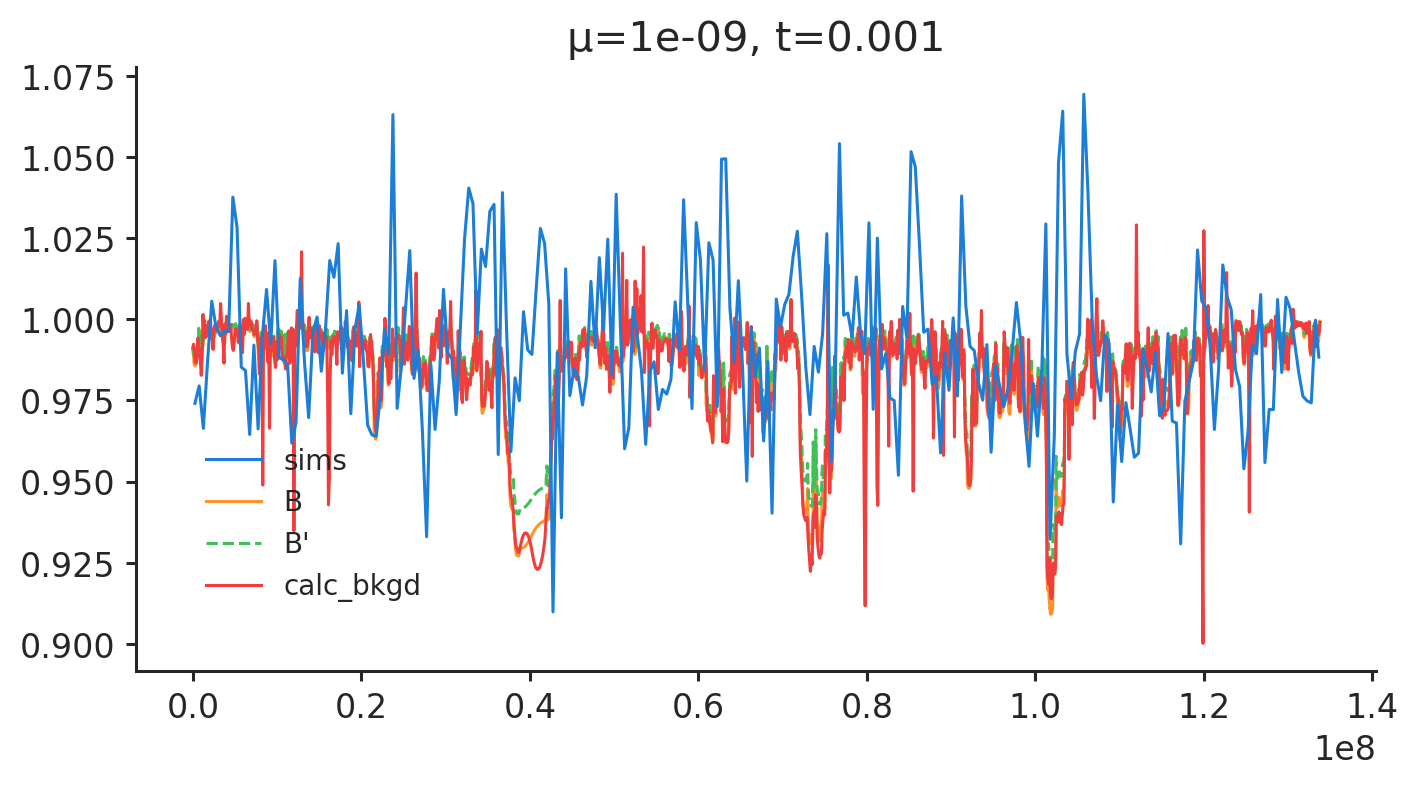

In [30]:
comparison_plot(1e-9, 0.001, b, bp, sims=sim_means_500kb, clcbg=mcvb)

Now, with even stronger selection:

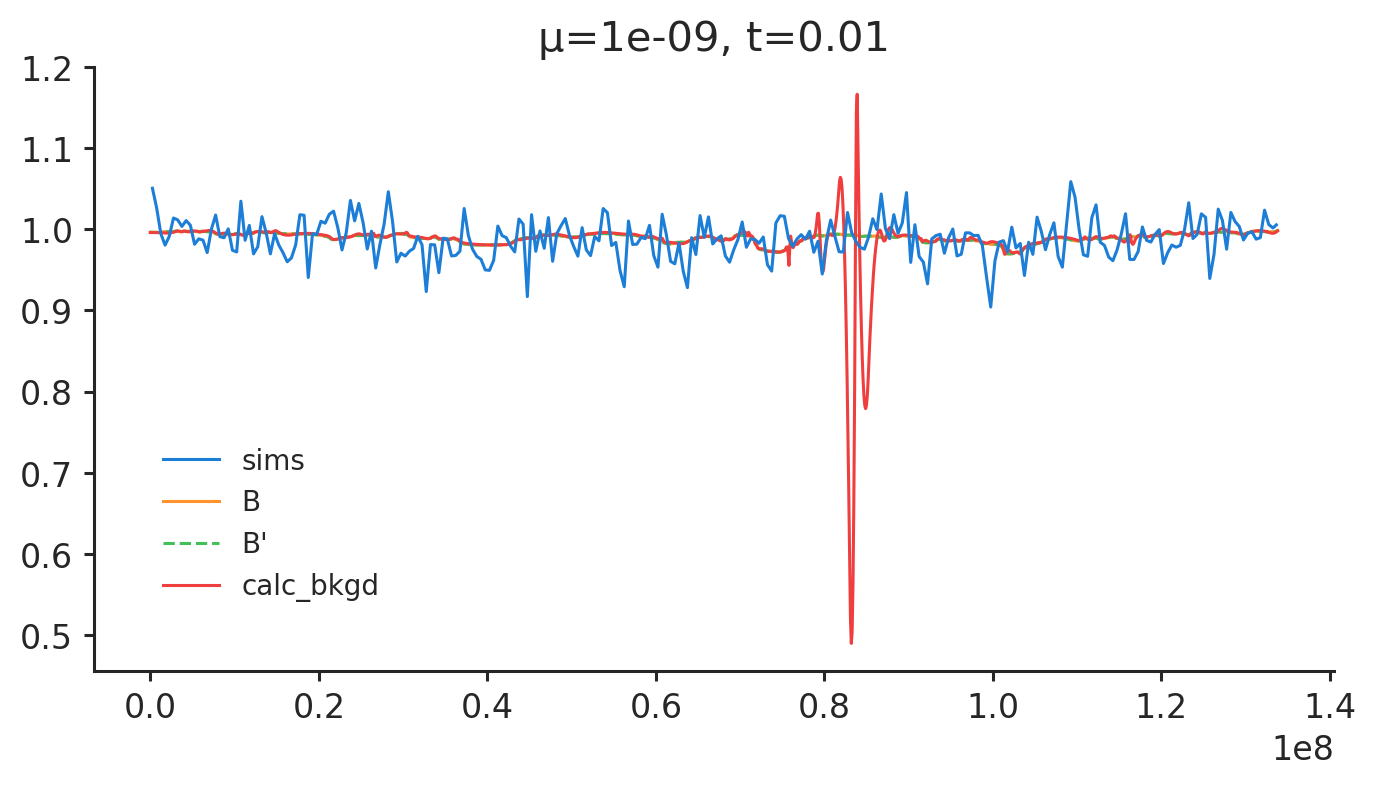

In [31]:
comparison_plot(m.w[2], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb)

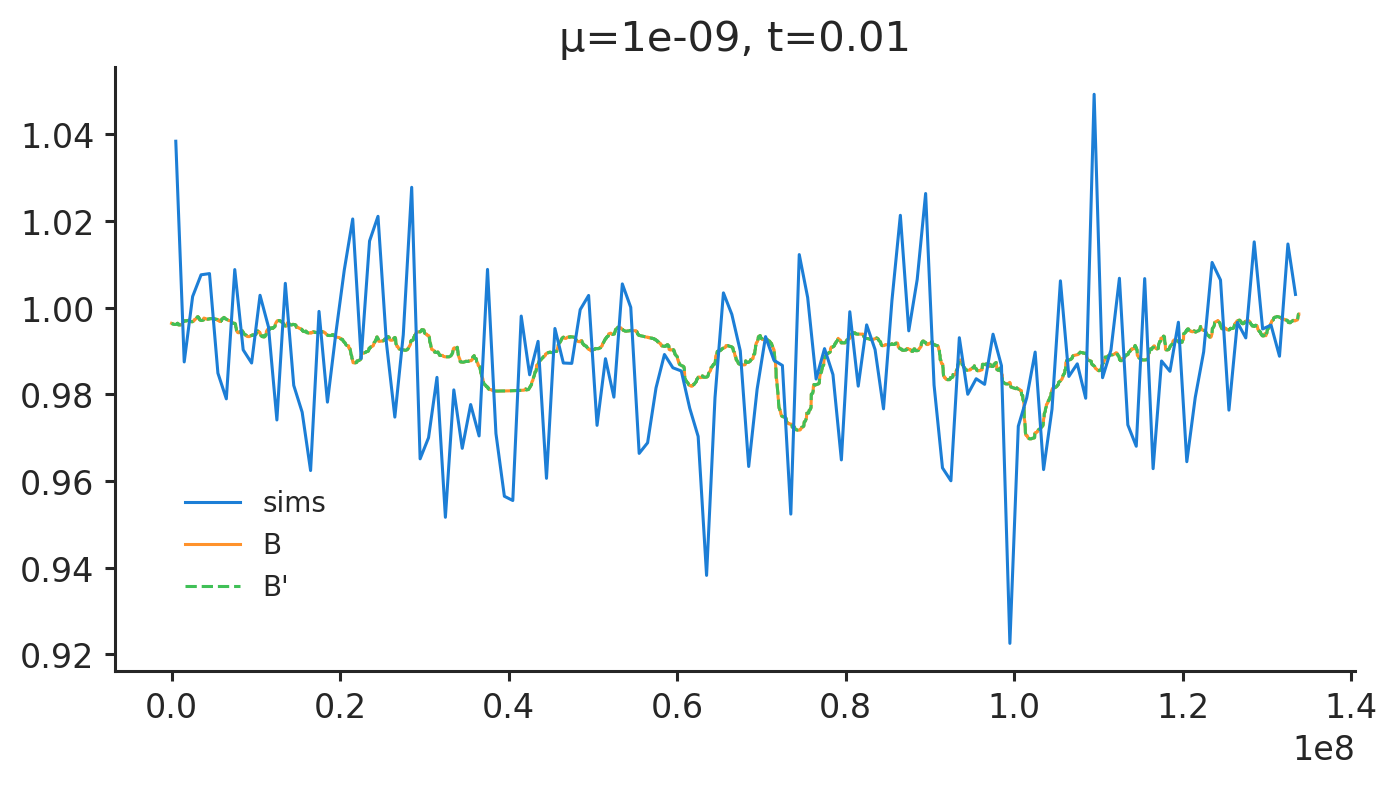

In [32]:
comparison_plot(m.w[2], m.t[4], b, bp, sims=sim_means_1Mb)

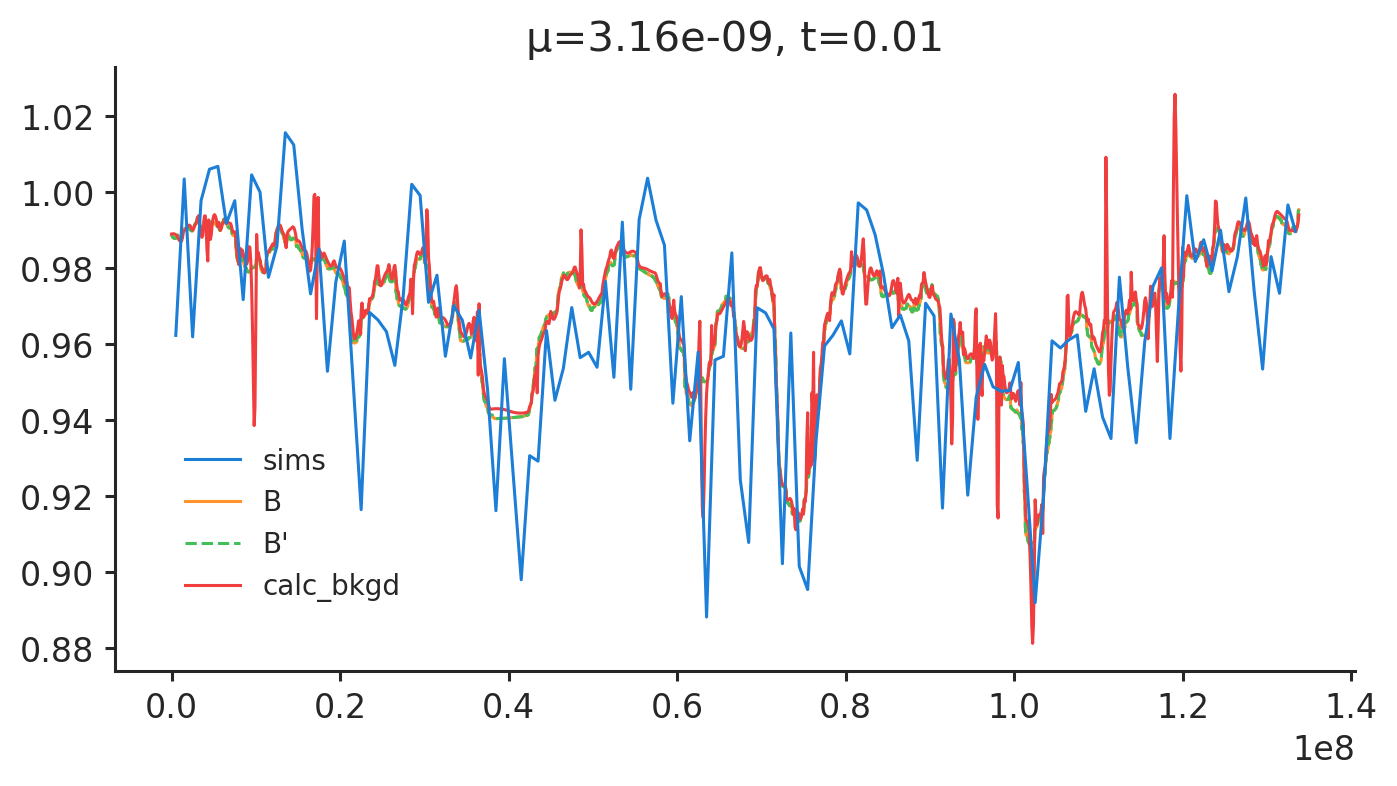

In [40]:
comparison_plot(m.w[3], m.t[4], b, bp, sims=sim_means_1Mb, clcbg=mcvb)

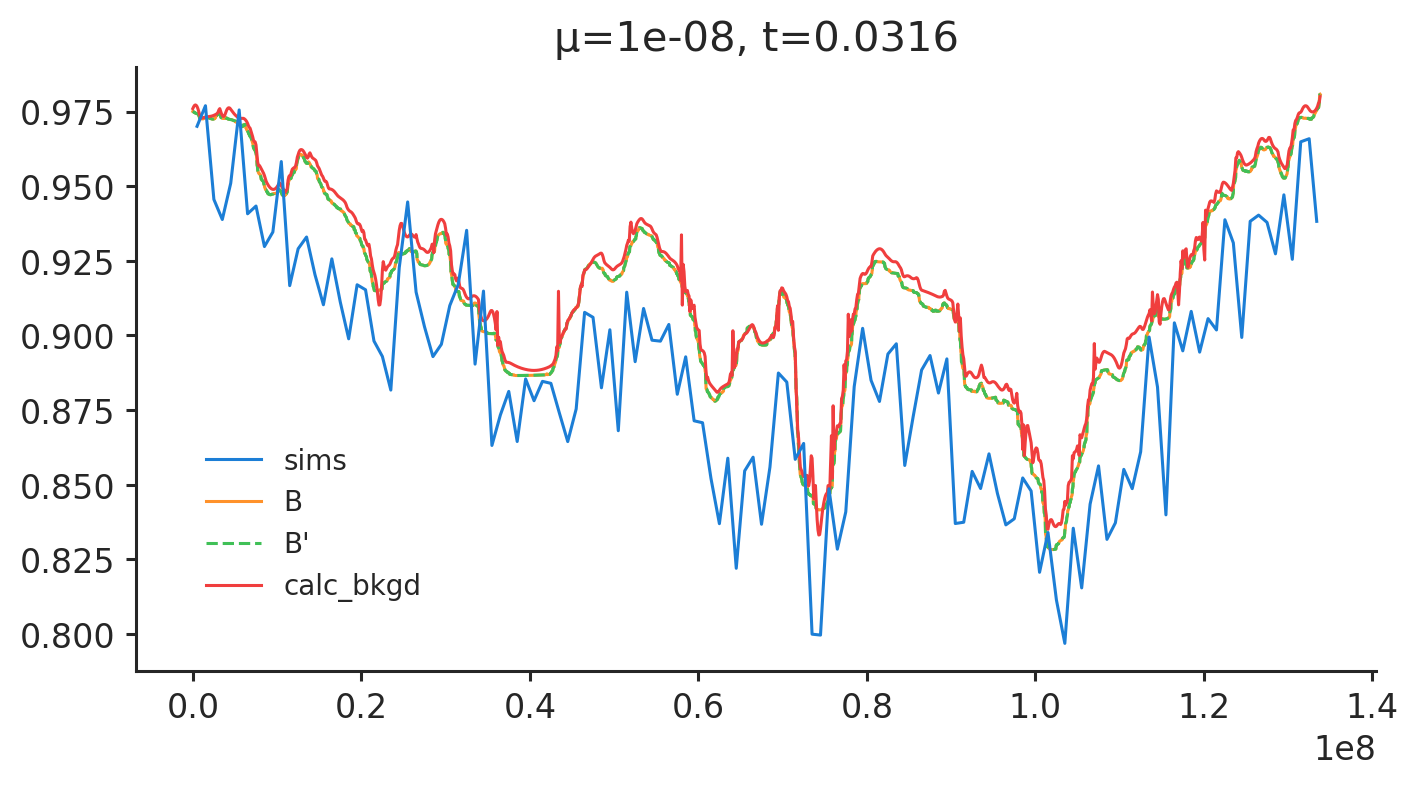

In [41]:
comparison_plot(m.w[4], m.t[5],  b, bp, sims=sim_means_1Mb, clcbg=mcvb)

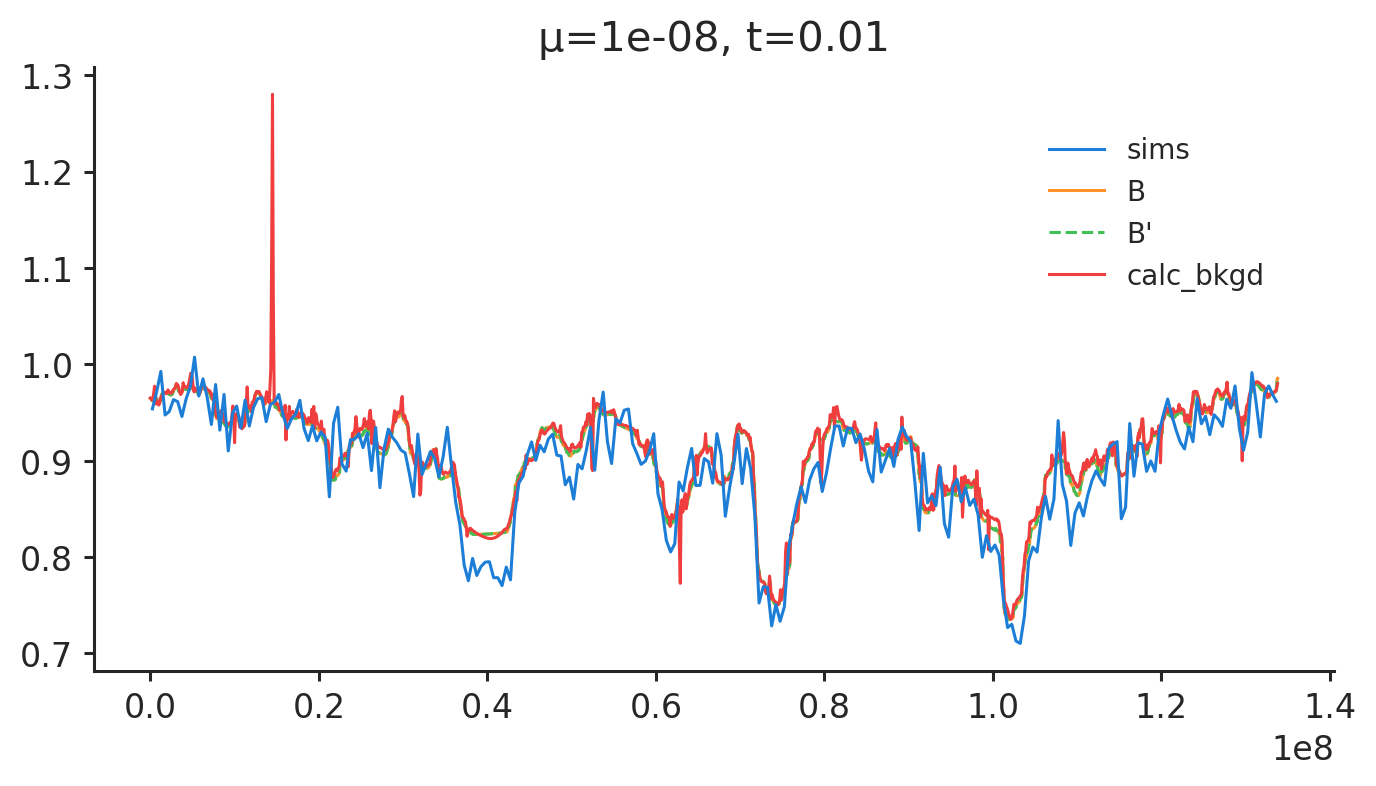

In [42]:
comparison_plot(m.w[4], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb)

(0.7, 1.1)

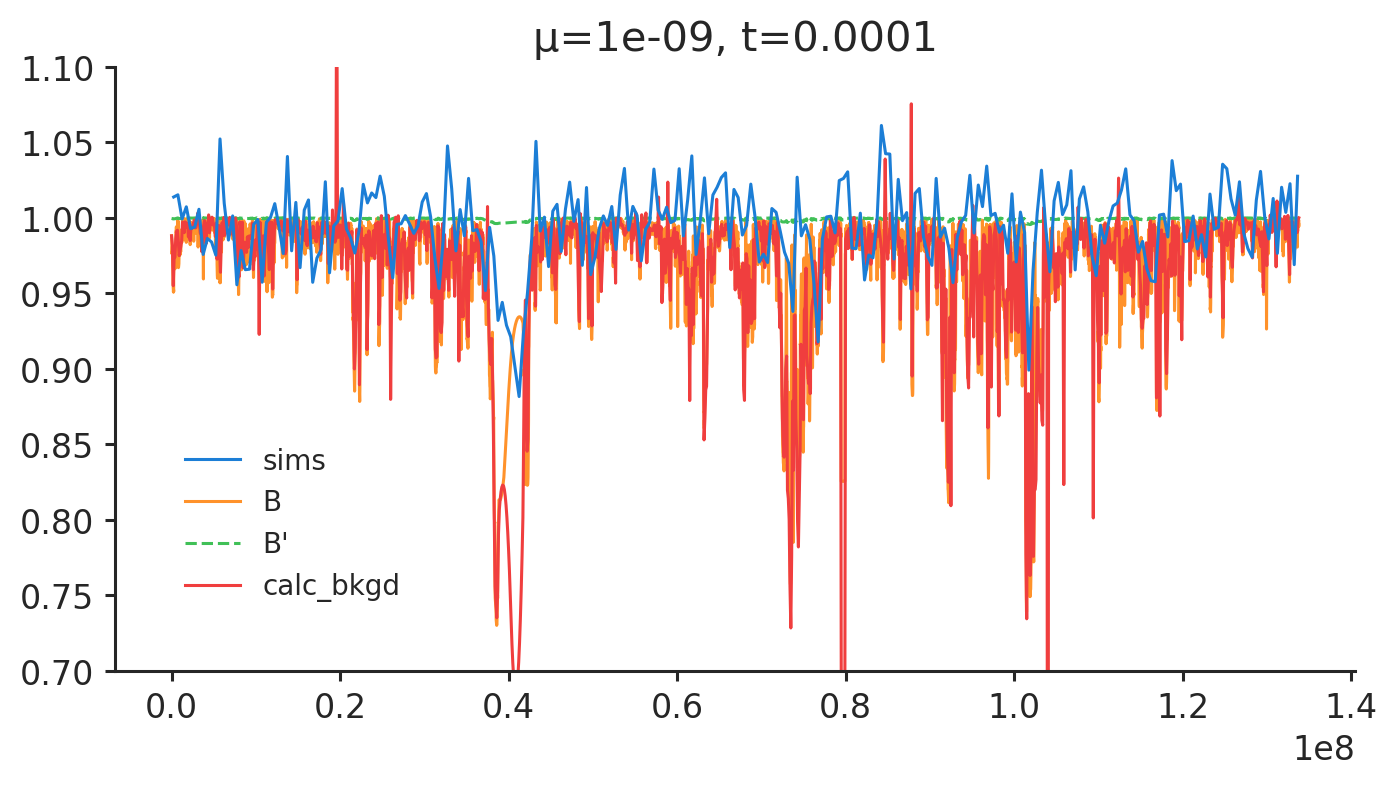

In [43]:
comparison_plot(1e-9, 0.0001, b, bp, sims=sim_means_500kb, clcbg=mcvb)
plt.ylim(0.7, 1.1)

## Analysis of Background Selection Signal Intensity

I calculate the signal intensity as $R^2$ between the simulation means $\bar{S}$ (across 100 replicates) and the $B'$ values.


In [44]:
from bgspy.likelihood import R2

def signal_intensity(w, t, b, sims):
    #nx, nw, nt, nf = b.shape
    bx, by = b.pairs('chr10', w, t)
    x, y = sims['chr10', w, t]
    assert bx.size == x.size, f"bin mismatch: {bx.size}, {x.size}"
    return R2(by, y)

signal_intensity(1e-8, 1e-4, bp.bin_means(GenomicBins(g.seqlens, 1_000_000)), sim_means_1Mb)


0.5166499396962909

In [45]:
R2s = []
ws, ts = [], []
for w, t in itertools.product(m.w, m.t):
    r2 = signal_intensity(w, t, bp.bin_means(GenomicBins(g.seqlens, 1_000_000)), sim_means_1Mb)
    R2s.append(r2)
    ws.append(w)
    ts.append(t)
    
df = pd.DataFrame(dict(w=ws, t=ts, R2=R2s))

In [46]:
df.head()

,w,t,R2
0,1.000000e-10,0.000100,0.207030
1,1.000000e-10,0.000316,-0.416210
2,1.000000e-10,0.001000,0.038939
3,1.000000e-10,0.003160,0.052138
4,1.000000e-10,0.010000,-0.201848


Text(0.5, 0, 'mutation rate')

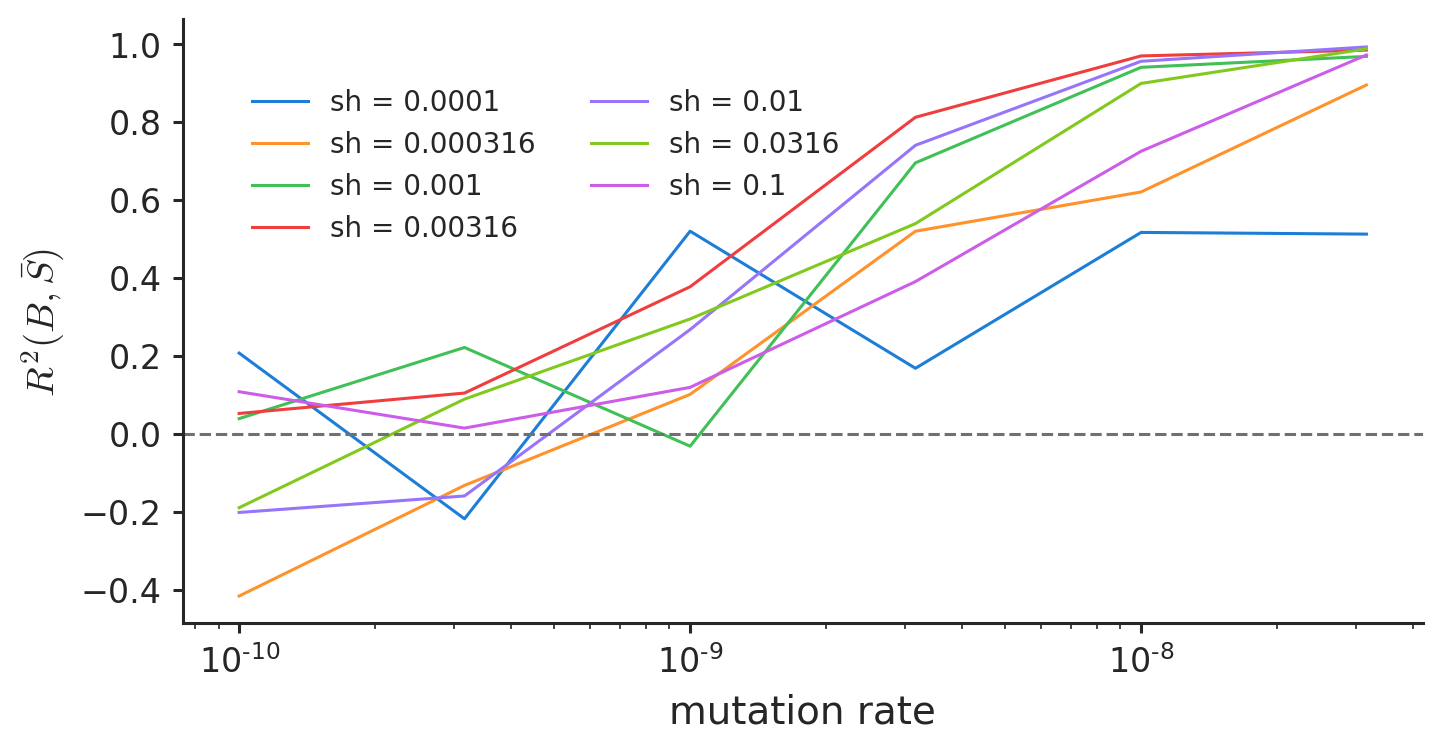

In [52]:
for t in m.t:
    ds = df.loc[df.t == t]
    plt.plot(ds.w, ds.R2, label=f"sh = {t}")
plt.semilogx()
plt.legend(loc='upper left', ncol=2)
plt.axhline(0, linestyle='dashed', c='0.44')
plt.ylabel('$R^2(B, \\bar{S})$')
plt.xlabel('mutation rate')

### Variance of the BGS process

What is the variance of the BGS process?

We estimate the variance across replicates in $B_\text{sim}$ as:

  $$
  \hat{\sigma}^2(B_\text{sim}) = \frac{1}{n-1} \sum_i (B_{\text{sim}, i} - \bar{B}_\text{sim})^2
  $$
  

$B_\text{sim}$ is estimated from the coalescent times of the simulation trees. Generally, it has a form like:

Note that if we use $\hat{B} = \pi / 4N$, $\text{Var}(\hat{B}) = \text{Var}(\pi)/4N^2$, which simplifies to (see Mathematica notebook):

$$\text{Var}(\hat{B}) = \frac{(n+1)}{3 (n-1)}\frac{\mu}{4N}+\frac{2 \left(n^2+n+3\right)}{9 (n-1) n}\mu^2 $$

$$\text{Var}(\hat{B}) = \frac{(n+1)}{3 (n-1)} \frac{\theta}{16N^2}  + \frac{2 \left(n^2+n+3\right)}{9 (n-1) n} \frac{\theta^2}{16N^2} $$
  

## Experiment: slop1k

In [72]:
slop1k = np.load('../data/chrombgs_chr10_merged_phastcons.npz')

In [73]:
slop1k_pos = (slop1k['pos'][1:] + slop1k['pos'][:-1])/2

In [74]:
slop1k['X'].shape

(133798, 6, 7, 50)

In [75]:
list(slop1k.keys())

['mu', 'sh', 'pos', 'X', 'nreps', 'mean', 'sd', 'files']

In [76]:
slop1k_sims = BScores({'chr10': np.log(slop1k['X'])}, {'chr10': sims_pos}, slop1k['mu'], slop1k['sh'], step=None)

In [77]:
slop1k_1Mb = slop1k_sims.bin_means(GenomicBins(g.seqlens, 1_000_000))


In [78]:
slop1k_1Mb

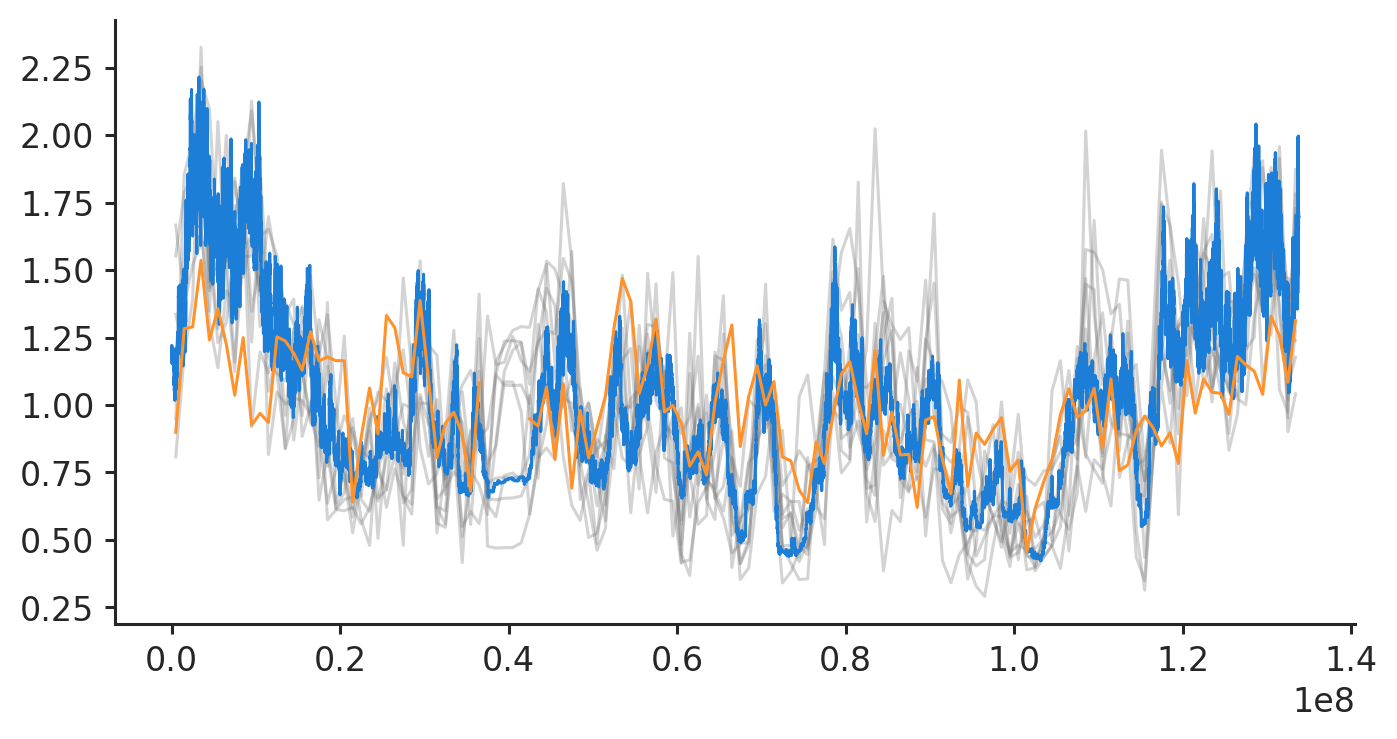

In [90]:
xx, yy = slop1k_1Mb['chr10', 1e-8, 1e-2]
for i in range(10):
    plt.plot(xx, mean_ratio(yy[:, i]), c='0.44', alpha=0.3)

sims_means = BScores({'chr10': np.log(slop1k['mean'])}, {'chr10': slop1k_pos}, slop1k['mu'], slop1k['sh'], step=None)
xx, yy = sims_means['chr10', 1e-8, 1e-2]
plt.plot(xx, mean_ratio(yy))
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, mean_ratio(dy), label="YRI data")

## Simulations

In [ ]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
pos = np.random.choice(sims_pos, 1000)

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr)

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    x = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    y = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]

    ax[j, i].scatter(x, y, s=3, c='0.22')
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='r', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    
plt.tight_layout()

In [ ]:
def B_bins(x, y, nbins):
    bm = stats.binned_statistic(x, y, np.nanmean, bins=nbins)
    mps = (bm.bin_edges[1:] + bm.bin_edges[:-1])/2
    return mps, bm.statistic

In [ ]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 10000
nbins = 50
idx = np.random.randint(0, len(sims_pos), n)
pos = sims_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(5, 6))

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)].squeeze()
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)].squeeze()
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(*B_bins(y, x, nbins), s=3)
    ax[j, i].scatter(*B_bins(ya, x, nbins), s=3)
    
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")

f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

In [ ]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

all_sim, all_bsc = [], []
all_s, all_mu = [], []
all_pos = []

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, ya, s=3, c=g.recmap.lookup('chr10', pos), norm=mpl.colors.LogNorm())
    all_s.extend([sh]*len(x))
    all_mu.extend([mu]*len(x))
    all_sim.extend(x.tolist())
    all_pos.extend(pos.tolist())
    all_bsc.extend(ya.tolist())
    #ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()